In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
from dataclasses import dataclass
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactocentric

from orbits.integrator import getPeriApoTime, getInjectionCoords, leapfrog

In [4]:
gc_frame = Galactocentric(
    galcen_distance = 8.29*u.kpc,
    z_sun=0*u.pc,
    galcen_v_sun = [11.1, 240.3+12.24, 7.25] * (u.km/u.s)
)

In [38]:
@dataclass
class dwarf_obs:
    ra: float
    dec: float
    
    distance: float
    pm_ra: float
    pm_dec: float
    radial_velocity: float
    
    distance_err: float = 0
    pm_ra_err: float = 0
    pm_dec_err: float = 0
    radial_velocity_err: float = 0

In [102]:
@dataclass
class dwarf_phase:
    x: float
    y: float
    z: float
    v_x: float
    v_y: float
    v_z: float

In [92]:
fornax_radec = SkyCoord(ra="2h39m59.3s", dec="-34d26m57s")

fornax_obs = dwarf_obs(
    ra = fornax_radec.ra/u.deg,
    dec = fornax_radec.dec/u.deg,
    distance = 143,
    distance_err = 3,
    pm_ra = 0.476 ,
    pm_ra_err = 0.046 ,
    pm_dec = -0.360,
    pm_dec_err = 0.041,
    radial_velocity = 55.3,
    radial_velocity_err = 0.1 
)

craterii_obs = dwarf_obs(
    ra = 177.3,
    dec = -18.4,
    distance=117.5,
    distance_err = 1.1,
    pm_ra = -0.246, 
    pm_ra_err = 0.052,
    pm_dec = -0.227,
    pm_dec_err = 0.026,
    radial_velocity = 87.5,
    radial_velocity_err = 0.4
)

In [93]:
np.random.seed(123)

In [106]:
def to_galcen(obs):
    sc = SkyCoord(ra = obs.ra * u.deg,
                  dec=obs.dec * u.deg,
                  distance = obs.distance * u.kpc,
                  radial_velocity = obs.radial_velocity * u.km/u.s,
                  pm_ra_cosdec = obs.pm_ra * u.mas/u.yr,
                  pm_dec = obs.pm_dec * u.mas/u.yr
                 )
    tc = sc.transform_to(gc_frame)
    x, y, z = [tc.x, tc.y, tc.z]
    vx, vy, vz = [tc.v_x, tc.v_y, tc.v_z]
    x /= u.kpc
    y /= u.kpc
    z /= u.kpc
    vx /= u.km/u.s
    vy /= u.km/u.s
    vz /= u.km/u.s
 
    return dwarf_phase(x, y, z, vx, vy, vz)

In [107]:
def rand_coords(obs, N):
    ra = np.full(N, obs.ra)
    dec = np.full(N, obs.dec)
    distance = np.random.normal(obs.distance,obs.distance_err, N)
    pm_ra = np.random.normal(obs.pm_ra,obs.pm_ra_err, N)
    pm_dec = np.random.normal(obs.pm_dec,obs.pm_dec_err, N)
    radial_velocity = np.random.normal(obs.radial_velocity,obs.radial_velocity_err, N)
    X = np.array([ra, dec, distance, pm_ra, pm_dec, radial_velocity])
    rand_obs = [dwarf_obs(*x) for x in X.transpose()]
    return rand_obs

In [126]:
def periApoHist(coords):
    periSet = np.array([])
    apoSet = np.array([])
    coordSet = []

    # print('multiprocessing...',end='\r')
    # pool = mp.Pool(nCores)
    # results = np.array(pool.map(helper, coords))
    # pool.close()
    # print('done multiprocessing')
    N = len(coords)
    peris = np.empty(N)
    apos = np.empty(N)
    filt = np.full(N, False)
    for i  in range(N):
        pc = to_galcen(coords[i])
        x = [pc.x, pc.y, pc.z]
        v = [pc.v_x, pc.v_y, pc.v_z]
        peri, apo, _ = getPeriApoTime(-4e9, -1e6, x, v)
        peris[i] = peri
        apos[i] = apo
        if peri is None or apo is None:
            continue
        if peri > 0 and apo > 0:
            filt[i] = True
            coordSet.append(pc)

    periSet = peris[filt]
    apoSet = apos[filt]
    return periSet,apoSet,coordSet


In [127]:
robs = rand_coords(fornax_obs, 100)
peris, apos, coords = periApoHist(robs)

In [132]:
percentiles = [16, 84]

present = {}

present["50"] = to_galcen(fornax_obs)

for per in percentiles:
    idx = np.argsort(peris)[int((len(peris) - 1) * per/100)]
    present[str(per)] = coords[idx]


In [134]:
past = {}
for per, coord in present.items():
    x = [coord.x, coord.y, coord.z]
    v = [coord.v_x, coord.v_y, coord.v_z]
    x2, v2, apo_time = getInjectionCoords(x, v, 10)
    past[per] = dwarf_phase(*x2, *v2)

In [135]:
present

{'50': dwarf_phase(x=<Quantity -40.31041437>, y=<Quantity -49.50327895>, z=<Quantity -130.28092123>, v_x=<Quantity -25.13923059>, v_y=<Quantity -142.14921861>, v_z=<Quantity 105.42942296>),
 '16': dwarf_phase(x=<Quantity -40.29196902>, y=<Quantity -49.4747626>, z=<Quantity -130.20587292>, v_x=<Quantity -18.24078157>, v_y=<Quantity -107.53645173>, v_z=<Quantity 90.72666675>),
 '84': dwarf_phase(x=<Quantity -40.44520913>, y=<Quantity -49.71167046>, z=<Quantity -130.82935838>, v_x=<Quantity 37.9237254>, v_y=<Quantity -156.01623741>, v_z=<Quantity 95.39501626>)}

In [136]:
past

{'50': dwarf_phase(x=-40.02779611239312, y=-158.44245376389176, z=51.63540309800509, v_x=0.17997999805496304, v_y=0.17209555502053023, v_z=0.6678257469733514),
 '16': dwarf_phase(x=53.22874592899056, y=127.55323659641137, z=66.97931169761925, v_x=-0.008066300267039002, v_y=0.2914049928276567, v_z=-0.5482836493116453),
 '84': dwarf_phase(x=6.5822759700013, y=-185.77659779273645, z=-7.320005564816616, v_x=0.21334658077810273, v_y=-0.01823724502063192, v_z=0.6531576083796462)}

Text(0, 0.5, 'density')

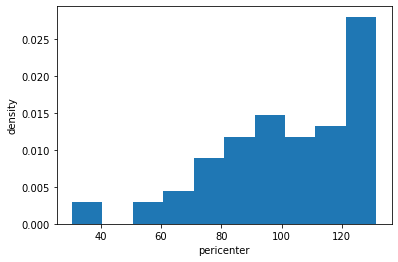

In [138]:
plt.hist(peris, density=True)
plt.xlabel("pericenter")
plt.ylabel("density")

Text(0, 0.5, 'density')

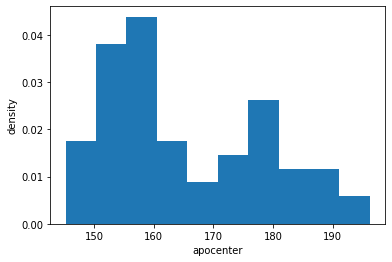

In [139]:
plt.hist(apos, density=True)
plt.xlabel("apocenter")
plt.ylabel("density")

In [ ]:
for key, val in present.items():
    x = 